# Triplet learning for bearing fault classification

The goal of this notebook is to train a classification model for bearing faults of rotating equipment. We want this model to be robust to different operating conditions, such as different machine loads or rotation velocity. Moreover, the model must not use characteristic information about the machine, such as the rotation velocity or the characteristic coefficients. For this reason, we will follow a Deep Learning approach.

The model consists of a Convolutional Neural Network splitted into two parts:

+ **The embedding**: It extracts valuable features from the training data, which will be then fed to the classifier. This embedding is trained using *Triplet Learning* strategies, which ensure that the extracted features are robust to different operating conditions. This technique is specially suitable for situations with very few data samples. 

+ **The classifier**: It takes as input the features extracted from the embedding and returns the type of fault of the bearing. It is trained using the typical cross entropy loss. 

We will use two data sets in order to train the model:

+ **IMS Nasa Bearing Data Center:** This dataset contains the time evolution of different bearings. At the end of the tests, some of these bearings suffer from faults. The goal of using this dataset is to be able to detect failures at early stages, that is, before they have been fully developed. For this reason, the waveform time series will be labeled using the Autoencoder Model, which is introduced in the notebook *Anomaly Detection- Autoencoder*, so that waveforms with early development of the failure will be labeled as being unhealthy. This data will be used in the training phase, so that the classification model will learn to detect early failure modes. 

+ **Paderborn Data Center**: This dataset also contains vibration data (waveforms) of different bearings, each suffering from a fault (inner ring, outer ring) or being healthy. The fault is completely developed.

We will mix the data from the two datasets in order to have different operating conditions for the different failures. 

Waveforms will be used as input for the classification model. Such waveforms will be previously preprocessed. In order to do so, we will apply a rolling window (with no overlap) that will split the long time series into smaller ones of 1000 data points. Also, the waveforms will be downsapled into 5000 Hz, which is the usual sampling frequency of real data. Finally, adaptive normalization will be applied. 

More details about the training process are provided in the following sections.


In [1]:
#Import needed packages

import scipy.io
import scipy
import scipy.signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow.keras import Model, layers
import pandas as pd
import umap
from sklearn.metrics import confusion_matrix, accuracy_score


sys.path.append('./Training')
sys.path.append('./Data')
sys.path.append('./Load_Data')
sys.path.append('./Models')

from IMS_data import Import_Data_IMS, Preprocessing_IMS
from Paderborn_data import Import_Data_Pad, Preprocessing_Pad, Load_Pad
from CNN_model import Embedding, Classification
from train_classifier import Training_classifier
from train_embeddings import Train_Embeddings
from pretraining import Pretraining


In [2]:
print(tf.__version__)

2.1.0


## Import data

We import the two files from the IMS Nasa Bearing Data Center. 
The datasets consist of two tests (Test1 and Test2), which contain the waveform time evolution of four bearings. Vibration data is collected with accelerometers. The bearings are of type Rexnord ZA-2115​.

The final state of each of the bearings is the following:

**Test1:**
+ Bearing 1 has an outer race defect which starts at around timestep 800
+ Bearing 2 is healthy
+ Bearing 3 is healthy
+ Bearing 4 has a rolling defect which starts at around timestamp 1800 

**Test2:**
+ Bearing 1 is healthy 
+ Bearing 2 is healthy
+ Bearing 3 has an inner race defect which starts at around timestep 1800
+ Bearing 4 is healthy


In the following class we will import the data from csv files and split it into four dataframes, one for each bearing.

In [3]:
test1 = Import_Data_IMS('Data/IMS/Test_1.csv')
test2 = Import_Data_IMS('Data/IMS/Test_2.csv')

The following lines of code put split the data into being healthy or having a fault (inner ring fault, outer ring fault and rolling element fault). In order to do wo, we use the labels obtained from the Autoencoder model, which tell us approximately in which timestamp the errors start their development.

In [4]:
#Define unhealthy data using the labels from the autoencoder model
inner = test1.t_2[1800:,:]
outer = test2.t_0[800:,:]
rolling = test1.t_3[1800:,:]

#For the healthy data, use waveforms from all tests
#We use a balanced dataset for healthy/unealthy data
idx = np.random.choice(np.arange(1300),70)
healthy1 = test1.t_2[idx,:]
idx = np.random.choice(np.arange(1300),70)
healthy2 = test1.t_3[idx,:]
idx = np.random.choice(np.arange(300),70)
healthy3 = test2.t_0[idx,:]

#Finally, concatenate all the healthy data
healthy  = np.concatenate([healthy1,healthy2,healthy3])



## Preprocessing

In order to preprocess data we performed the following steps:

+ Downsampling from 20000 Hz to 5000 Hz in order to have data more similiar to the real productio data.

+ Rolling window for each waveform, to reduce the size of the wavevorm to 1000 timestamps (instead of 5000) and to obtain more samples from the same waveform. There is no overlap.

+ Adaptative normalization: minmax scaling.

+ Shuffle samples.

+ Split of training and test sets.

In [5]:
prep = Preprocessing_IMS(inner, outer, rolling, healthy)

X_train_IMS, X_test_IMS, y_train_IMS, y_test_IMS = prep.get_X_y()

## Load Paderborn data

Paderborn data contains time series of the vibration of rotating equipment (bearings). It contains two different rotation speeds (900 rpm and 1500 rpm). The dataset contains data from healthy bearings, and from two different types of faults: inner ring fault and outer ring fault. The faults are completely developed at the beginning of the time series.  


In [6]:
data_Pad = Import_Data_Pad('Data/Paderborn/K001/N15/', 'Data/Paderborn/K001/N09/', 'Data/Paderborn/KI01/N15/', 
                       'Data/Paderborn/KI01/N09/', 'Data/Paderborn/KA01/N15/', 'Data/Paderborn/KA01/N09/')

## Preprocessing

In order to preprocess data we performed the following steps:

+ Downsampling from 20000 Hz to 5000 Hz in order to have data more similiar to the real production data.

+ Rolling window for each waveform, to reduce the size of the wavevorm to 1000 timestamps (instead of 5000) and to obtain more samples from the same waveform. There is no overlap.

+ Adaptative normalization: minmax scaling.

+ Adding noise 

+ Shuffle samples.

+ Split of training and test sets.

The noise is introduced in two different ways:

+ Amplify the amplitude of the 4rth first harmonics.

+ Introduce white noise (random frequencies and amplitudes) within a frequency band of 750-1000Hz.

To visualize such noise, refer to the notebook *Siamese network for bearing fault classification*.
We add noise so that the data resembles more to real data. 

In [7]:
#Create preprocessing object
prep = Preprocessing_Pad()

#Load Paderborn data
load_Pad = Load_Pad(prep, data_Pad.healthy_files09, data_Pad.healthy_files15,data_Pad.inner_files09,
                     data_Pad.inner_files15,data_Pad.outer_files09, data_Pad.outer_files15)

X_train_Pad, X_test_Pad, y_train_Pad, y_test_Pad, load_train_Pad, load_test_Pad = load_Pad.get_X_y()

Data/Paderborn/K001/N09/N09_M07_F10_K001_1.mat


./Load_Data\Paderborn_data.py:253: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data_train = pd.concat([data_train, aux])
./Load_Data\Paderborn_data.py:255: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data_test = pd.concat([data_test, aux])


Data/Paderborn/K001/N09/N09_M07_F10_K001_10.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_11.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_12.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_13.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_14.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_15.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_16.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_17.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_18.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_19.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_2.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_20.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_3.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_4.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_5.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_6.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_7.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_8.mat
Data/Paderborn/K001/N09/N09_M07_F10_K001_9.mat
Data/Paderborn/K001/N15/N15_M07_F10_K001_1.mat
Data/Paderborn/K001/N15/N15_M07_F10_K001_10.mat
D

## Join datasets

In [8]:
X_train = np.concatenate((X_train_Pad, X_train_IMS), axis=0)
X_test = np.concatenate((X_test_Pad, X_test_IMS), axis=0) 

y_train = np.concatenate((y_train_Pad, y_train_IMS), axis=0) 
y_test = np.concatenate((y_test_Pad,  y_test_IMS), axis=0) 

load_train = np.concatenate((load_train_Pad,  np.repeat(6, y_train_IMS.shape[0])), axis=0)
load_test = np.concatenate((load_test_Pad,  np.repeat(6, y_test_IMS.shape[0])), axis=0) 

Mix everything

In [9]:
#Shuffle indeces so that the loads/defects are not ordered
idx = np.arange(X_train.shape[0])
np.random.shuffle(idx)
X_train = X_train[idx,:]
y_train = y_train[idx]
load_train = load_train[idx]

idx = np.arange(X_test.shape[0])
np.random.shuffle(idx)
X_test = X_test[idx,:]
y_test = y_test[idx]
load_test = load_test[idx]

This is the code to load the embedding and classification models from the path where the weights are saved.

In [37]:
def load_model(filepath, learning_rate = 0.001, net = 'classification'):
    """
    Loads the embedding and classification models.
    Args:
        filepath (str): Path of the saved weights
        learning_rate (float): Learning rate of the Adam optimizer
    Returns:
        embedding (Model): Embedding model
        classification (Model): Classification model
    """
    #Redefine model
    embedding = Embedding()
    classification = Classification(embedding)

    optimizer = tf.optimizers.Adam(learning_rate)
    if net=='classification':
        ckpt = tf.train.Checkpoint(optimizer=optimizer, net=classification)
    else:
        ckpt = tf.train.Checkpoint(optimizer=optimizer, net=embedding)

    manager = tf.train.CheckpointManager(ckpt, directory = filepath , max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")

    return embedding, classification

# Example of use:
# embedding, classification = load_model("Weights/TL/classifier/training/", learning_rate = 0.0001 )

## Pretraining: Simple CNN

We start by pre training the CNN with cross entropy loss, because it is a very stable loss function. This pre trained model will be used later to train the embeddings and the final classification model. 

We first define the hyperparameters: learning rate, training iterations, batch size, input size of the CNN, number of classification outputs.


In [22]:
# Training parameters
learning_rate = 0.001
training_iters = 250
batch_size = 16
display_step = 10
filepath = "Weights/TL/classifier/pretraining/"

# Network Parameters
n_input = 1000 # Length of input data
num_classes = 4  # number of classes


### Embeddings

Next, we define the structure of the embedding network:

It consists of a 1D neural network, with the input the temporal series (waveform). 

The CNN has 4 1D Convolutional layers with 32,32,32 and 64 filters respectively, height=10, strides=4 and padding='same'. We have 3 MaxPooling subsampling layers with pool size = 10, strides = 4. Then we have 2 FC with 32 nodes, and another with 20 output nodes. This last layer is the output of the embedding- All layers have Relu activation function. This embedding will be used later on to classify the faults into different faults.

### Classification model

The classification model takes as input the output of the embedding model, and adds 3 Fc layers, with 64, 64 and 32 filters each. The output is the number of types of defects (4). During the pretraining process, all layers will be trained using cross entropy loss.

You can skip the next cell and load the saved weights directly.


In [12]:
#Pretraining phase
# Build neural network model.
embedding = Embedding()
conv_net = Classification(embedding)

#Create pretraining object
pretrain = Pretraining( conv_net, learning_rate, training_iters, batch_size, display_step, filepath, restore=False)

#Fit model
pretrain.fit( X_train, y_train, save=False)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

step: 10, loss: 1.350916, accuracy: 0.312500
step: 20, loss: 1.370483, accuracy: 0.312500
step: 30, loss: 1.292670, accuracy: 0.437500
step: 40, loss: 1.351225, accuracy: 0.375000
step: 50, loss: 1.336320, accuracy: 0.437500
step: 60, loss: 1.294878, accuracy: 0.500000
step: 70, loss: 1.227773, accuracy: 0.562500
step: 80, loss: 1.184950, accuracy: 0.750000
step: 90, loss: 1.238543, accuracy: 0.625000
step: 100, loss: 1.209464, accuracy: 0.375000
step: 110, loss: 1.203836, accuracy: 0.687500
step: 120, 

In [23]:
# Comment this line to use the model you just trained, and not the loaded weights
embedding, conv_net = load_model("Weights/TL/classifier/pretraining/")

# Test model on validation set.
pred= conv_net(X_test)
emb = embedding(X_test)

y_pred = np.argmax(pred.numpy(), axis=1)
print('Confusion matrix:' , confusion_matrix(y_test, y_pred))

print("Test Accuracy: %f" % accuracy_score(y_pred, y_test))

Restored from Weights/TL/classifier/pretraining/ckpt-1

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast

## Visualization of embeddings: UMAP

We perform a UMAP to visualize the embeddings extracted from the embedding model. For more information about UMAP see the notebook *Siamese network ofr bearing fault classification.*


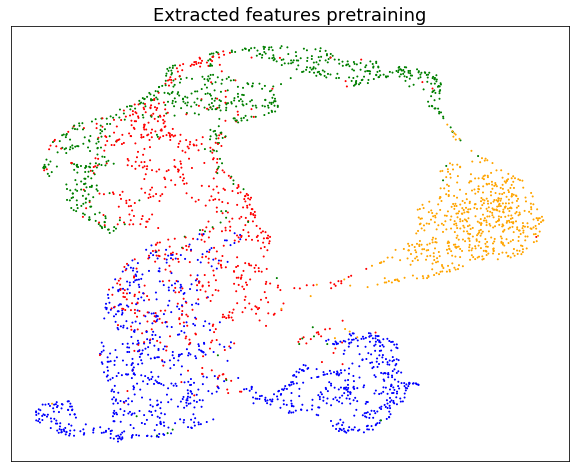

In [13]:
features = emb

#Create UMAP embedding to 2 dimensions
embed = umap.UMAP(n_neighbors=10,
                      min_dist=0.5,
                      metric='correlation').fit_transform(features)

#Choose colors
color = pd.DataFrame(y_test,columns=['color'])
color.replace({0:'red', 1:'blue', 2:'green', 3:'orange'},inplace=True)

#Create plots
fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(embed[:,0], embed[:,1], 
            c=color.values.flatten(),
            cmap="Spectral", 
            s=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Extracted features pretraining", fontsize=18)

plt.show()


We observe that the cross entropy loss function already creates fairly good embeddings. However, we will use triplet loss to obtain even better embeddings that will (hopefully) help the classifier increase its performance.

## Triplet learning

Here we give a brief explanation of triplet loss, and some references for further details. Just as the Siamese network, triplet strategies are also designed to create useful em-beddings for data samples.

The goal of the triplet loss is to make sure that:

+ Two examples with the **same label** (same failure) have their embeddings **close together** in the embedding space
+ Two examples with **different labels** (different faults) have their embeddings **far away**.


The way to ensure so is by requiring that given two examples from the same class and an example from a different class, this different example should be farther away than the two same examples by a margin. 

To formalise this requirement, the loss will be defined over triplets of embeddings:

+ an **anchor**
+ a **positive** of the same class as the anchor
+ a **negative** of a different class

Let $G_W$ be a neural network with weights $W$, which is responsible of producing the waveform embeddings. Let $a,p,n$ be an anchor, a positive and a negative sample respectively.   For some distance on the embedding space $d$ (usually the euclidean distance), the loss of a triplet $(a,p,n)$ is:

\begin{equation}
\mathcal{L}(a,p,n) = \max(d(G_W(a),G_W(p)) - d(G_W(a),G_W(n)) + margin, 0)
\end{equation}

By minimizing the loss $\mathcal{L}$, we push $d(G_W(a),G_W(n))$ to be greater than $d(G_W(a),$ $G_W(p))$ by a margin $margin$. When this condition is satisfied the loss function becomes zero. The total loss function is then:

\begin{equation}
    \mathcal{L}(W) = \sum_{\substack{a,p,n\\
    Y_a = Y_p \neq Y_n}} max(d(G_W(a),G_W(p)) - d(G_W(a),G_W(n)) + margin, 0)
\end{equation}



## Triplet mining 

Based on the definition of the loss, there are three categories of triplets:

1. **easy triplets:**  triplets which have a loss equals to zero, because 
$$ d(G_W(a),G_W(p))+ margin < d(G_W(a),G_W(n))$$

2. **hard triplets:** triplets where the negative is closer to the anchor than the positive:$$ d(G_W(a),G_W(n)) < d(G_W(a),G_W(p))$$

3. **semi-hard triplets:** triplets where the negative is not closer to the anchor than the positive, but which still have positive loss: 

$$
d(G_W(a),G_W(p)) < d(G_W(a),G_W(n)) < d(G_W(a),G_W(p)) +  margin
$$

The loss function for easy triplets is already zero, so these triplets do not help to train the embedding network. Therefore, choosing the good triplets to train the network is crutial to achieve a good performance. There are two basic strategies to "mine" triplets:

### 1. Offline triplet mining: 

With thia approach we compute all the triplets at the beggining of an epoch, and only train on the hard or semi-hard triplets. 
Overall this technique is not very efficient since we need to do a full pass on the training set to generate triplets. It also requires to update the offline mined triplets regularly.

### 2. Online triplet mining:

The other strategy is to select the triplets for every batch, and train the network with those triplets. This technique gives you more triplets for a single batch of inputs, and does not require any offline mining. It is therefore much more efficient. There are two basic strategies in online triplet mining:

+ **Batch all strategy**: select all the valid triplets (triplets containing an anchor, a positive and a negative sample), and average the loss on the hard and semi-hard triplets.

$$
\mathcal{L}_{Hard}(W) = \sum_{i=1}^K \sum_{a=1}^P \max( \max_{p=1,\cdots, P} d(G_W(a^i),G_W(p^i)) \\ 
            - \min_{\substack{j=1,\cdots, K\\
            n=1, \cdots, P\\
            j \neq i}}d(G_W(a^i),G_W(n^i)) + margin,0)
$$


+ **Batch hard strategy**:  for each anchor, select the hardest positive (biggest distance $d(G_W(a),G_W(p))$) and the hardest negative among the batch.

$$
\mathcal{L}_{All}(W) = \sum_{i=1}^k \sum_{a=1}^P \sum_{\substack{p=1\\ p\neq a}}^P \sum_{\substack{j=1\\ j\neq i}}^K \sum_{n=1}^P  max(d(G_W(a^i),G_W(p^i)) \\ 
             - d(G_W(a^i),G_W(n^j)) + margin, 0)
$$

The batch all strategy is specially suitable when the number of data samples is small, since it produces many more samples that the ones in the training data. On the other hand, when the dataset is large enough the batch hard strategy has proven to have very good results.

In this notebook we will use online triplet mining, with both 'batch all' and 'batch hard' strategies. 

For more information on triplet learning, check the following references:

+ Florian Schroff, Dmitry Kalenichenko, and James Philbin. *FaceNet: A UnifiedEmbedding for Face Recognition and Clustering*. In: (2015), pp. 815–823.DOI: 10.1109/CVPR.2015.7298682

+  Olivier  Moindrot. *Triplet  Loss  and  Online  Triplet  Mining  in  TensorFlow.* 2018. URL: https://omoindrot.github.io/triplet-loss

+  Alexander Hermans, Lucas Beyer, and Bastian Leibe. *In Defense of the TripletLoss for Person Re-Identification*. 


## Training the embeddings

Now that we have a good initialization for the Weights from the pretrained model, we perform triplet loss optimization of the embeddings. 

We first define the hyperparameters for this part: learning rate, training iterations, batch size, margin, triplet strategy, embedding size and input size.  



In [69]:
# Parameters
learning_rate = 0.0001
training_iters = 50
batch_size = 64

#Triplet parameters
margin = 1.0
squared=False
triplet_strategy='batch_all' #'batch_hard' 
filepath = "Weights/TL/embedding/"

# Network Parameters
n_input = 1000 # Length of input data
embedding_size = 20 # length of embedding features 


In [59]:
#Function to get batches from training data
def get_all_batches(data,labels,batch_size):
    '''
    Gets all the batches from existing dataset.

    Args:
    data (numpy array): X data
    labels (numpy array): y data
    batch_size (int): Batch size

    Returns:
    batches_x (list of numpy array): list of batches for X data
    batches_y (list of numpy array): list of batches for y data
    num_batches (int): Number of batches
    '''
    #Shuffle data
    idx = np.arange(0,data.shape[0])
    np.random.shuffle(idx)

    data_shuffle = data[idx,:]
    labels_shuffle = labels[idx]

    #Crop data to make it multiple to the batch size
    labels_shuffle = labels_shuffle[0:labels.shape[0] - labels.shape[0]%batch_size]
    data_shuffle = data_shuffle[0:labels.shape[0] - labels.shape[0]%batch_size,:]

    #Get X, y batches
    num_batches = data_shuffle.shape[0]/batch_size 
    batches_x =np.split(data_shuffle,num_batches)
    batches_y =np.split(labels_shuffle,num_batches)

    return batches_x,batches_y,num_batches


We train the embeddings using triplet loss. You can skip this cell and load the pretrained weights in the following cell. The training can take a while (especially if not using GPU). 

In [60]:
#Train embeddings with triplet learning

# Build neural network model.
_,_,num_batches = get_all_batches(X_train,y_train,batch_size)

#Define embeddings
train_emb = Train_Embeddings( embedding, learning_rate, int(num_batches*training_iters), batch_size,
                             display_step, triplet_strategy, margin, squared, filepath, restore=False)

train_emb.fit(X_train, y_train, save=True)

step:  10 Loss 4.0876155 Fraction positive triplets 0.06269526
step:  20 Loss 3.0446453 Fraction positive triplets 0.027604798
step:  30 Loss 5.123899 Fraction positive triplets 0.05260568
step:  40 Loss 3.453728 Fraction positive triplets 0.07468862
step:  50 Loss 2.4212928 Fraction positive triplets 0.015880715
step:  60 Loss 2.957599 Fraction positive triplets 0.05601956
step:  70 Loss 1.9911752 Fraction positive triplets 0.06239716
step:  80 Loss 1.6308917 Fraction positive triplets 0.025149548
step:  90 Loss 2.1008577 Fraction positive triplets 0.038373258
step:  100 Loss 1.8009677 Fraction positive triplets 0.043662995
step:  110 Loss 1.8937122 Fraction positive triplets 0.021302728
step:  120 Loss 1.8540034 Fraction positive triplets 0.031342153
step:  130 Loss 1.795446 Fraction positive triplets 0.061411805
step:  140 Loss 1.6762086 Fraction positive triplets 0.021556122
step:  150 Loss 1.5714896 Fraction positive triplets 0.024294157
step:  160 Loss 2.2511196 Fraction positive

step:  1140 Loss 0.40696087 Fraction positive triplets 0.000106464526
step:  1150 Loss 0.35080662 Fraction positive triplets 0.00025189974
step:  1160 Loss 0.45820576 Fraction positive triplets 0.0009598531
step:  1170 Loss 2.6422856 Fraction positive triplets 0.0075022634
step:  1180 Loss 0.74675417 Fraction positive triplets 0.001973768
step:  1190 Loss 0.74833935 Fraction positive triplets 0.0016108247
step:  1200 Loss 0.0 Fraction positive triplets 0.0
step:  1210 Loss 0.43164492 Fraction positive triplets 0.0007904632
step:  1220 Loss 1.4342036 Fraction positive triplets 0.0054540094
step:  1230 Loss 0.54647523 Fraction positive triplets 0.00062586326
step:  1240 Loss 0.46240482 Fraction positive triplets 0.0009423456
step:  1250 Loss 0.71770316 Fraction positive triplets 0.00081826013
step:  1260 Loss 0.1790576 Fraction positive triplets 6.465517e-05
step:  1270 Loss 1.2358398 Fraction positive triplets 0.00520184
step:  1280 Loss 0.0 Fraction positive triplets 0.0
step:  1290 Lo

step:  2410 Loss 0.0 Fraction positive triplets 0.0
step:  2420 Loss 0.69071954 Fraction positive triplets 0.00048982026
step:  2430 Loss 0.0 Fraction positive triplets 0.0
step:  2440 Loss 0.27237424 Fraction positive triplets 0.00030019728
step:  2450 Loss 0.3855044 Fraction positive triplets 0.00012925464
step:  2460 Loss 0.0 Fraction positive triplets 0.0
step:  2470 Loss 0.0 Fraction positive triplets 0.0
step:  2480 Loss 0.73937833 Fraction positive triplets 0.0009155949
step:  2490 Loss 0.39876056 Fraction positive triplets 4.3105305e-05
step:  2500 Loss 0.0 Fraction positive triplets 0.0
step:  2510 Loss 0.0 Fraction positive triplets 0.0
step:  2520 Loss 0.8814419 Fraction positive triplets 0.0011778807
step:  2530 Loss 0.555184 Fraction positive triplets 0.00043162983
step:  2540 Loss 0.0 Fraction positive triplets 0.0
step:  2550 Loss 0.14572 Fraction positive triplets 2.1321053e-05
step:  2560 Loss 0.0 Fraction positive triplets 0.0
step:  2570 Loss 0.0 Fraction positive tr

step:  3800 Loss 0.64549965 Fraction positive triplets 0.0011711097
Saved checkpoint for step Weights/TL/embedding/ckpt-1


In [72]:
# Comment this line to use the model you just trained and 
embedding, conv_net = load_model("Weights/TL/embedding/", net="emb")

emb2 = embedding(X_test)

Restored from Weights/TL/embedding/ckpt-1

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



We visualize the embeddings using UMAP

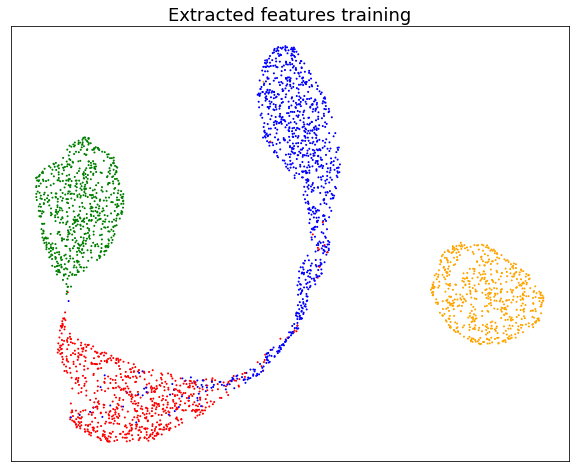

In [73]:
features = emb2

#Create UMAP embeddings into 2 dimensions
embed= umap.UMAP(n_neighbors=100,
                      min_dist=0.5,
                      metric='correlation').fit_transform(features)
#Choose colors
color = pd.DataFrame(y_test,columns=['color'])
color.replace({0:'red', 1:'blue', 2:'green', 3:'orange'},inplace=True)

#Create plots
fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(embed[:,0], embed[:,1], 
            c=color.values.flatten(),
            cmap="Spectral", 
            s=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Extracted features training", fontsize=18)

plt.show()


We observe that the embeddings are better after training the model with triplet loss. We hope that with these embeddings the classifier will have a better performance.

## Classification model using triplet loss embeddings

Now that we have trained the embeddings using triplet loss, we will train the classifier using cross entropy loss. During this training the embedding layers will be frozen.



In [74]:
#Parameters
num_classes = 4
batch_size= 64
training_iters = 2000
learning_rate=0.001
filepath = "Weights/TL/classifier/training/"

In [75]:
#Create trianing classifier object
classifier = Training_classifier(conv_net, learning_rate, training_iters, batch_size, display_step,filepath, restore=False)
#train classifier
classifier.fit(X_train, y_train, save=True)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

step: 10, loss: 0.757455, accuracy: 1.000000
step: 20, loss: 0.745108, accuracy: 1.000000
step: 30, loss: 0.744229, accuracy: 1.000000
step: 40, loss: 0.744530, accuracy: 1.000000
step: 50, loss: 0.744250, accuracy: 1.000000
step: 60, loss: 0.743963, accuracy: 1.000000
step: 70, loss: 0.743913, accuracy: 1.000000
step: 80, loss: 0.743961, accuracy: 1.000000
step: 90, loss: 0.744404, accuracy: 1.000000
step: 100, loss: 0.744011, accuracy: 1.000000
step: 110, loss: 0.744104, accuracy: 1.000000
step: 120, 

step: 400, loss: 0.743720, accuracy: 1.000000
step: 410, loss: 0.743731, accuracy: 1.000000
step: 420, loss: 0.743722, accuracy: 1.000000
step: 430, loss: 0.743786, accuracy: 1.000000
step: 440, loss: 0.743770, accuracy: 1.000000
step: 450, loss: 0.743715, accuracy: 1.000000
step: 460, loss: 0.743709, accuracy: 1.000000
step: 470, loss: 0.743728, accuracy: 1.000000
step: 480, loss: 0.743748, accuracy: 1.000000
step: 490, loss: 0.743715, accuracy: 1.000000
step: 500, loss: 0.743714, accuracy: 1.000000
step: 510, loss: 0.743738, accuracy: 1.000000
step: 520, loss: 0.743885, accuracy: 1.000000
step: 530, loss: 0.743710, accuracy: 1.000000
step: 540, loss: 0.743719, accuracy: 1.000000
step: 550, loss: 0.743726, accuracy: 1.000000
step: 560, loss: 0.743723, accuracy: 1.000000
step: 570, loss: 0.743704, accuracy: 1.000000
step: 580, loss: 0.743744, accuracy: 1.000000
step: 590, loss: 0.743868, accuracy: 1.000000
step: 600, loss: 0.743716, accuracy: 1.000000
step: 610, loss: 0.743760, accurac

We check the final accuracy

In [78]:
# Comment this line to use the model you just trained and not the saved weights
embedding, conv_net = load_model("Weights/TL/classifier/training/")

# Test model on validation set.
pred= conv_net(X_test)
y_pred = np.argmax(pred.numpy(), axis=1)
print("Test Accuracy: %f" % accuracy_score(y_pred, y_test))

Restored from Weights/TL/classifier/training/ckpt-1

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Test Accuracy: 0.958155


We observe that we obtain a high accuracy, which is a noticeable improvement with respect to the pretraining accuracy. We can conclude that the triplet loss has helped to obtain a better classification accuracy. Moreover, the only missclassification happens between healthy and inner ring samples, which are the most difficult to classify. 

In [66]:
confusion_matrix(y_test, y_pred)

array([[732,  17,   1,   0],
       [103, 886,   1,   0],
       [  0,   0, 705,   0],
       [  0,   1,   0, 589]], dtype=int64)